### Fitting the image sharpness (DCTS metric) by ETL offset parameter
Example 2: A total of 21 images are acquired at various ETL offsets (near-optimal $v_0$, $v_0 \pm 500 mV$, at steps 50 mV), with L, R-arm, 488nm, 561nm illumination.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tifffile
import sys
import os
import time
import glob

In [2]:
utils_path = '../../../mesoSPIM/src/'
if os.path.exists(utils_path):
    sys.path.append('../../../mesoSPIM/src/')
else:
    print('Error: check your path to utils module')

In [3]:
from utils import optimization as opt

In [4]:
img_folder = 'D:/Raw/2021-07-07-etl-AMRbrain/etl-offset-step50mV-LR-488-561/'
tif_files = glob.glob(img_folder + "*.tif")
meta_files = [ fname + "_meta.txt" for fname in tif_files]
len(meta_files)

84

In [5]:
meta_files[0]

'D:/Raw/2021-07-07-etl-AMRbrain/etl-offset-step50mV-LR-488-561\\20210707-170202.tif_meta.txt'

In [6]:
def nonblank_lines(f):
    for l in f:
        line = l.rstrip()
        if line:
            yield line

In [7]:
meta_list = []

for tif, meta in zip(tif_files, meta_files):
    meta_dict = {}
    with open(meta) as f:
        lines = nonblank_lines(f)
        for line in lines:
            if line.split()[0] == "[Zoom]":
                meta_dict["zoom"] = line.split()[1]
            elif line.split()[0] == "[Shutter]":
                meta_dict["shutter"] = line.split()[1]
            elif line.split()[0] == "[etl_l_offset]":
                meta_dict["etl_l_offset"] = float(line.split()[1])
            elif line.split()[0] == "[etl_r_offset]":
                meta_dict["etl_r_offset"] = float(line.split()[1])
            elif line.split()[0] == "[Laser]":
                meta_dict["laser"] = line.split()[1]
    meta_dict["tif"] = tif
    meta_list.append(meta_dict)

In [8]:
meta_list[0]

{'laser': '488',
 'zoom': '1x',
 'shutter': 'Right',
 'etl_l_offset': 2.2500000000000133,
 'etl_r_offset': 2.0,
 'tif': 'D:/Raw/2021-07-07-etl-AMRbrain/etl-offset-step50mV-LR-488-561\\20210707-170202.tif'}

In [9]:
dim_y, dim_x = tifffile.imread(meta_list[0]['tif']).shape
print(dim_y, dim_x)

2048 2048


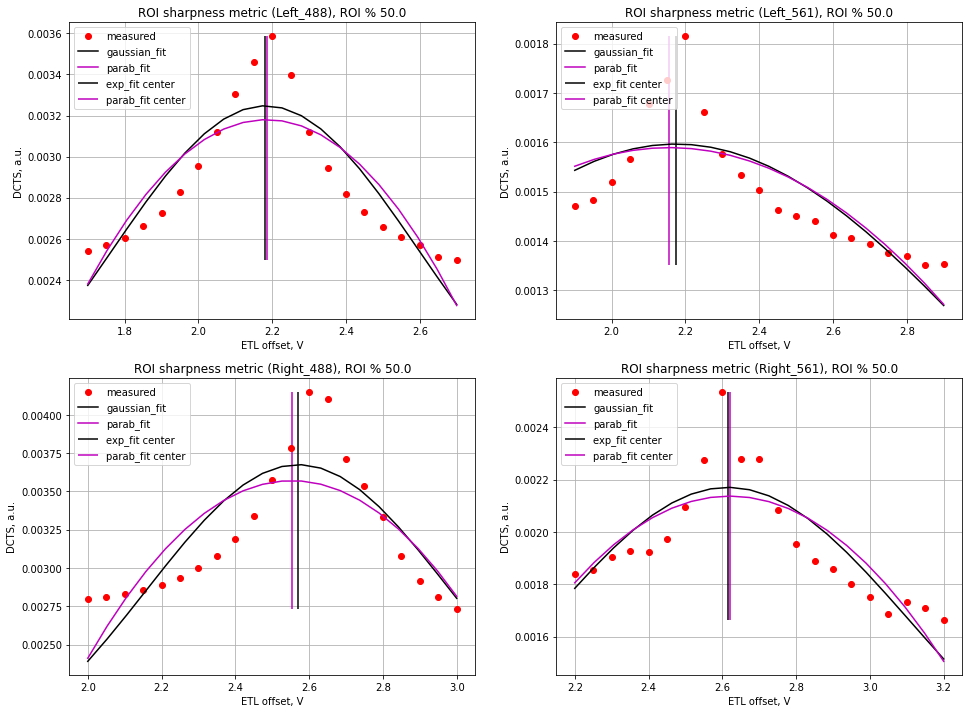

In [96]:
# how much percent of the image width does the ROI occupy.
roi_perc = 50.
slice_x = slice(int(dim_x * (50 - roi_perc/2)/100), int(dim_x * (50 + roi_perc/2)/100))

fig = plt.figure(figsize=(16,12))
i_plot = 0
for shutter in ("Left", "Right"):
    for laser in ("488", "561"):
        list_metafiles = [m for m in meta_list if (m['laser']==laser and m['shutter']==shutter)]
        roi_metrics = []
        etl_offsets = []
        for exp in list_metafiles:
            img = tifffile.imread(exp['tif'])
            roi = img[:,slice_x]
            roi_metrics.append(opt.shannon_dct(roi))
            if shutter == "Right":
                etl_offsets.append(exp['etl_r_offset'])
            else:
                etl_offsets.append(exp['etl_l_offset'])

        # sort the data points and fit them
        etl_offsets_sort = sorted(etl_offsets)
        roi_metrics_sort = [m for o, m in sorted(zip(etl_offsets, roi_metrics))]
        
        f_points, x_points = np.array(roi_metrics_sort), np.array(etl_offsets_sort)
        fit_center, fit_sigma, fit_amp, fit_offset = opt.fit_gaussian_1d(f_points, x_points)
        parab_fit_center, parab_fit_amp, parab_fit_offset = opt.fit_parabola_1d(f_points, x_points)
        
        i_plot += 1
        plt.subplot(2, 2, i_plot)
        key = shutter + "_" + laser
        etl_offset_grid = np.linspace(etl_offsets_sort[0], etl_offsets_sort[-1], 20)
        plt.plot(etl_offsets_sort, roi_metrics_sort, "or", label="measured")
        plt.plot(etl_offset_grid, opt._gaussian_1d(etl_offset_grid, fit_center, fit_sigma, fit_amp, fit_offset), 'k', 
                label="gaussian_fit",)
        plt.plot(etl_offset_grid, opt._parabola_1d(etl_offset_grid, parab_fit_center, parab_fit_amp, parab_fit_offset), 'm', 
                label="parab_fit",)
        plt.vlines(fit_center, f_points.min(), f_points.max(), 'k', label="exp_fit center")
        plt.vlines(parab_fit_center, f_points.min(), f_points.max(), 'm', label="parab_fit center")

        plt.grid(True)
        plt.legend() 
        plt.legend(loc='upper left')
        plt.ylabel("DCTS, a.u.")
        plt.xlabel("ETL offset, V")
        plt.title(f"ROI sharpness metric ({key}), ROI % {roi_perc}")
        
        ## Resave TIFFs as stacks, ordered by ETL values
        #tiff_stack = np.empty((len(etl_offsets_sort), *roi.shape))
        tiff_sort = [m['tif'] for o, m in sorted(zip(etl_offsets, list_metafiles))]
        etl_step = np.diff(etl_offsets)
        assert np.allclose(etl_step, etl_step[0]), "ETL values are not equally spaced"
        
        with tifffile.TiffWriter(img_folder + key + '.tiff', imagej=True) as writer:
            for i, tiff in enumerate(tiff_sort):
                roi = tifffile.imread(tiff)[:,slice_x]
                writer.save(roi[np.newaxis,...], contiguous=True, metadata={'spacing': etl_step[0]}) #python 3.6. Use .write() for >=3.7

In [97]:
fig.savefig(img_folder + f"ROIperc_{roi_perc}.png", format='png')

### Conclusions so far
 * Sharpness metric is sensitive to ROI size
 * Gaussian and parabolic fit give nearly equivalent results
 * DCTS is sensitive to some image features more than others, so the results can be biased dep on the features present in the ROI.
 * DCTS can actually show a **dip** at the optimal ETL offset in a sample that has many sparse blobs, because their number suddenly drops at the optimal ETL offset, due to better sectioning. However, if the ETL search grid is sufficiently large, this single drop can be compensated by overall trend.
 * larger ROI, e.g. 40%, gives smoother plots of sharpness metric than smaller ones, and probably better optimum estimates.
 
 ### Next
 Test with a different kind of sample, label, and channel.